In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.formula.api as sm
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Cargar el archivo 
df = pd.read_csv('/home/saul/Escritorio/ROSY/Metastasis/dataset.csv', encoding='latin-1')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EXPEDIENTE                  466 non-null    int64  
 1   EDAD                        466 non-null    int64  
 2   SEXO                        466 non-null    object 
 3   TUMOR PRIMARIO              466 non-null    object 
 4   SUBTIPO HISTOLOGICO         466 non-null    object 
 5   PERFIL MOLECULAR            466 non-null    object 
 6   AÑO                         466 non-null    float64
 7    No. METS                   466 non-null    object 
 8   TAMAÑO (mm)                 466 non-null    object 
 9   LOCALIZACION                466 non-null    object 
 10  CIRUGIA PREVIA              466 non-null    object 
 11  SRS                         466 non-null    object 
 12  DOSIS (Gy)                  466 non-null    int64  
 13  TECNICA                     466 non

In [5]:
# Se observa que hay valores no numéricos que hay que eliminar
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].str.replace(r'[^\d.]', '', regex=True)

# los valores que quedan vacios se deben reemplar ćon NaN para poder convertir a float
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].replace('', np.nan)

# Verificar las filas con el valor problemático
problemas = df[df['TAMAÑO (mm)'] == '20240611000000']

# Reemplazar valor problematico
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].replace('20240611000000', np.nan)

# Convertir la columna a tipo float
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].astype(float)

In [6]:
# Agrupar por las columnas deseadas y calcular el promedio de tamaño
grouped_data = df.groupby(['EDAD', 'SEXO', 'TUMOR PRIMARIO', ' No. METS'])['TAMAÑO (mm)'].agg(['mean'])

# Renombrar la columna 'mean' a 'Promedio de Tamaño'
grouped_data = grouped_data.rename(columns={'mean': 'Promedio de Tamaño'})

# Reiniciar el índice para que las columnas de agrupación sean columnas regulares
grouped_data = grouped_data.reset_index()

# Mostrar la tabla
print(grouped_data)

     EDAD SEXO         TUMOR PRIMARIO  No. METS  Promedio de Tamaño
0      24    F         CANCER DE MAMA         1                13.0
1      24    F         CANCER DE MAMA         2                13.9
2      24    F         CANCER DE MAMA         3                16.4
3      24    F         CANCER DE MAMA         4                54.1
4      30    M      CANCER DE ESOFAGO         1                16.2
..    ...  ...                    ...       ...                 ...
384    79    F               MELANOMA         1                27.9
385    84    M     CANCER DE PROSTATA         1                35.2
386    87    F       CANCER DE PULMON         1                12.0
387    87    F       CANCER DE PULMON         2                 9.0
388    93    F  CANCER CERVICOUTERINO         1                22.0

[389 rows x 5 columns]


In [7]:
# Agrupar por 'TUMOR PRIMARIO' y calcular el promedio de 'Promedio de Tamaño'
tumor_primario_grouped = grouped_data.groupby('TUMOR PRIMARIO')['Promedio de Tamaño'].mean()

# Mostrar la tabla resultante
print(tumor_primario_grouped)

TUMOR PRIMARIO
CANCER CERVICOUTERINO     22.000000
CANCER DE COLON           25.000000
CANCER DE ENDOMETRIO      25.914286
CANCER DE ESOFAGO         13.450000
CANCER DE MAMA            15.423450
CANCER DE OVARIO          14.607500
CANCER DE PROSTATA        35.200000
CANCER DE PULMON           9.594556
CANCER DE TIROIDES         6.684848
CANCER RENAL              19.597719
CANCER TESTICULAR         23.350000
MELANOMA                  12.517059
TUMOR NEUROECTODERMICO    17.000000
TUMOR NEUROENDOCRINO      18.600000
Name: Promedio de Tamaño, dtype: float64


In [8]:
# Agrupar por 'TUMOR PRIMARIO' y 'No. METS', calcular el promedio de 'Promedio de Tamaño'
tumor_mets_grouped = grouped_data.groupby(['TUMOR PRIMARIO', ' No. METS'])['Promedio de Tamaño'].mean()

# Mostrar la tabla resultante
print(tumor_mets_grouped)

TUMOR PRIMARIO          No. METS
CANCER CERVICOUTERINO  1            22.0
CANCER DE COLON        1            25.0
CANCER DE ENDOMETRIO   1            32.1
                       2            22.0
                       3             9.0
                                    ... 
TUMOR NEUROENDOCRINO   5            23.2
                       6            19.7
                       7            28.6
                       8            16.0
                       9            18.2
Name: Promedio de Tamaño, Length: 137, dtype: float64


In [9]:
df.head()

,EXPEDIENTE,EDAD,SEXO,TUMOR PRIMARIO,SUBTIPO HISTOLOGICO,PERFIL MOLECULAR,AÑO,No. METS,TAMAÑO (mm),LOCALIZACION,CIRUGIA PREVIA,SRS,DOSIS (Gy),TECNICA,TRATAMIENTO SISTEMICO,RESPUESTA (CRITERIOS RANO),ID_unico,RESPUESTA_BINARIA
0,209406,55,F,CANCER DE MAMA,CARCINOMA DUCTAL INFILTRANTE,TRIPLE NEGATIVO,2016.0,1,26.00,PARIETAL IZQ,SI,DU (dosis única),16,VMAT,CAPECITABINE,RESPUESTA COMPLETA,arVYSawGyncamwxDvEFq2p,1
1,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,1,17.00,FRONTAL DER,NO,DU (dosis única),20,VMAT,SORAFENIB,ESTABLE,fXjbGDzCmb8uvRK9WLJVsF,1
2,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,2,4.55,FRONTAL DER,NO,DU (dosis única),22,VMAT,PAZOPANIB,RESPUESTA PARCIAL,9jYiY9yM7nYu3k2CcnxQUz,1
3,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,3,3.44,CEREBELO,NO,DU (dosis única),22,VMAT,PAZOPANIB,RESPUESTA PARCIAL,i8VWomMqG92GyenK6f9vMJ,1
4,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,4,4.90,CEREBELO,NO,DU (dosis única),22,VMAT,PAZOPANIB,ESTABLE,E2BccD5k4nE3KBf7FvpeUa,1


ANALISIS CON LOS DATOS AGRUPADOS POR PACIENTE.

In [10]:
df.columns = df.columns.str.strip()  # Elimina espacios al inicio y final
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Reemplaza espacios por guiones bajos

print(df.columns)

Index(['EXPEDIENTE', 'EDAD', 'SEXO', 'TUMOR_PRIMARIO', 'SUBTIPO_HISTOLOGICO',
       'PERFIL_MOLECULAR', 'AÑO', 'No._METS', 'TAMAÑO_(mm)', 'LOCALIZACION',
       'CIRUGIA_PREVIA', 'SRS', 'DOSIS_(Gy)', 'TECNICA',
       'TRATAMIENTO_SISTEMICO', 'RESPUESTA_(CRITERIOS_RANO)', 'ID_unico',
       'RESPUESTA_BINARIA'],
      dtype='object')


In [11]:
# Creando una columna  por paciente para sumar el número de tumores
df['NUM_TUMORES'] = df.groupby('EXPEDIENTE').cumcount() + 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EXPEDIENTE                  466 non-null    int64  
 1   EDAD                        466 non-null    int64  
 2   SEXO                        466 non-null    object 
 3   TUMOR_PRIMARIO              466 non-null    object 
 4   SUBTIPO_HISTOLOGICO         466 non-null    object 
 5   PERFIL_MOLECULAR            466 non-null    object 
 6   AÑO                         466 non-null    float64
 7   No._METS                    466 non-null    object 
 8   TAMAÑO_(mm)                 464 non-null    float64
 9   LOCALIZACION                466 non-null    object 
 10  CIRUGIA_PREVIA              466 non-null    object 
 11  SRS                         466 non-null    object 
 12  DOSIS_(Gy)                  466 non-null    int64  
 13  TECNICA                     466 non

In [13]:
df_consolidado = df.groupby('EXPEDIENTE').agg({
    'EDAD': 'first',
    'SEXO': 'first',
    'TUMOR_PRIMARIO': 'first',
    'TAMAÑO_(mm)': ['mean', 'max', 'min'],  # Asegúrate de que el nombre sea correcto
    'LOCALIZACION': lambda x: x.nunique(),
    'NUM_TUMORES': 'count',
    'SRS': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',
    'TECNICA': 'first',
    'DOSIS_(Gy)': lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Moda de la dosis,
    'RESPUESTA_BINARIA': 'first'
}).reset_index()
 
df_consolidado.info()
# Aplanar las columnas con join
df_consolidado.columns = ['_'.join(col).strip() for col in df_consolidado.columns]

# Renombrar RESPUESTA_BINARIA_first a RESPUESTA_BINARIA
df_consolidado.rename(columns={'RESPUESTA_BINARIA_first': 'RESPUESTA_BINARIA'}, inplace=True)

print(df_consolidado.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (EXPEDIENTE, )              97 non-null     int64  
 1   (EDAD, first)               97 non-null     int64  
 2   (SEXO, first)               97 non-null     object 
 3   (TUMOR_PRIMARIO, first)     97 non-null     object 
 4   (TAMAÑO_(mm), mean)         97 non-null     float64
 5   (TAMAÑO_(mm), max)          97 non-null     float64
 6   (TAMAÑO_(mm), min)          97 non-null     float64
 7   (LOCALIZACION, <lambda>)    97 non-null     int64  
 8   (NUM_TUMORES, count)        97 non-null     int64  
 9   (SRS, <lambda>)             97 non-null     object 
 10  (TECNICA, first)            97 non-null     object 
 11  (DOSIS_(Gy), <lambda>)      97 non-null     int64  
 12  (RESPUESTA_BINARIA, first)  97 non-null     int64  
dtypes: float64(3), int64(6), object(4)
me

In [14]:
# Definir los grupos de edad
bins = [0, 18, 30, 45, 60, 75, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76-100']

# Crear una nueva columna para los grupos de edad
df_consolidado['Grupo_Edad'] = pd.cut(df_consolidado['EDAD_first'], bins=bins, labels=labels, right=False)


# Calcular frecuencias
frecuencias = df_consolidado.groupby(['TUMOR_PRIMARIO_first', 'SEXO_first', 'Grupo_Edad']).size().reset_index(name='Frecuencia')

# Mostrar la tabla de frecuencias
print(frecuencias)

# Tabla pivotada
tabla_resumen = frecuencias.pivot_table(
    index='TUMOR_PRIMARIO_first', 
    columns=['SEXO_first', 'Grupo_Edad'], 
    values='Frecuencia', 
    fill_value=0
)

# Mostrar la tabla de resumen
print(tabla_resumen)

      TUMOR_PRIMARIO_first SEXO_first Grupo_Edad  Frecuencia
0    CANCER CERVICOUTERINO          F       0-18           0
1    CANCER CERVICOUTERINO          F      19-30           0
2    CANCER CERVICOUTERINO          F      31-45           0
3    CANCER CERVICOUTERINO          F      46-60           0
4    CANCER CERVICOUTERINO          F      61-75           0
..                     ...        ...        ...         ...
163   TUMOR NEUROENDOCRINO          M      19-30           0
164   TUMOR NEUROENDOCRINO          M      31-45           0
165   TUMOR NEUROENDOCRINO          M      46-60           1
166   TUMOR NEUROENDOCRINO          M      61-75           0
167   TUMOR NEUROENDOCRINO          M     76-100           0

[168 rows x 4 columns]
SEXO_first                F                                   M              \
Grupo_Edad             0-18 19-30 31-45 46-60 61-75 76-100 0-18 19-30 31-45   
TUMOR_PRIMARIO_first                                                          
CANCER 

/tmp/ipykernel_422/14671086.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frecuencias = df_consolidado.groupby(['TUMOR_PRIMARIO_first', 'SEXO_first', 'Grupo_Edad']).size().reset_index(name='Frecuencia')
/tmp/ipykernel_422/14671086.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabla_resumen = frecuencias.pivot_table(


In [15]:
# Crear la tabla de contingencia sin valores ni aggfunc
tabla_contingencia = pd.crosstab(
    index=df_consolidado['TUMOR_PRIMARIO_first'],  # Índice: Tipo de Tumor Primario
    columns=[df_consolidado['SEXO_first'], df_consolidado['Grupo_Edad']],  # Columnas: Sexo y Grupos de Edad
    dropna=False  # Mantener categorías con valores NaN
)

# Mostrar la tabla de contingencia
print(tabla_contingencia)

SEXO_first                F                                   M              \
Grupo_Edad             0-18 19-30 31-45 46-60 61-75 76-100 0-18 19-30 31-45   
TUMOR_PRIMARIO_first                                                          
CANCER CERVICOUTERINO     0     0     0     0     0      1    0     0     0   
CANCER DE COLON           0     0     0     0     0      0    0     0     0   
CANCER DE ENDOMETRIO      0     0     0     3     1      0    0     0     0   
CANCER DE ESOFAGO         0     0     0     0     0      0    0     0     1   
CANCER DE MAMA            0     1     7    23     8      1    0     0     0   
CANCER DE OVARIO          0     0     0     4     1      0    0     0     0   
CANCER DE PROSTATA        0     0     0     0     0      0    0     0     0   
CANCER DE PULMON          0     0     1     6     3      1    0     0     2   
CANCER DE TIROIDES        0     0     0     0     2      0    0     0     0   
CANCER RENAL              0     0     0     3     3 

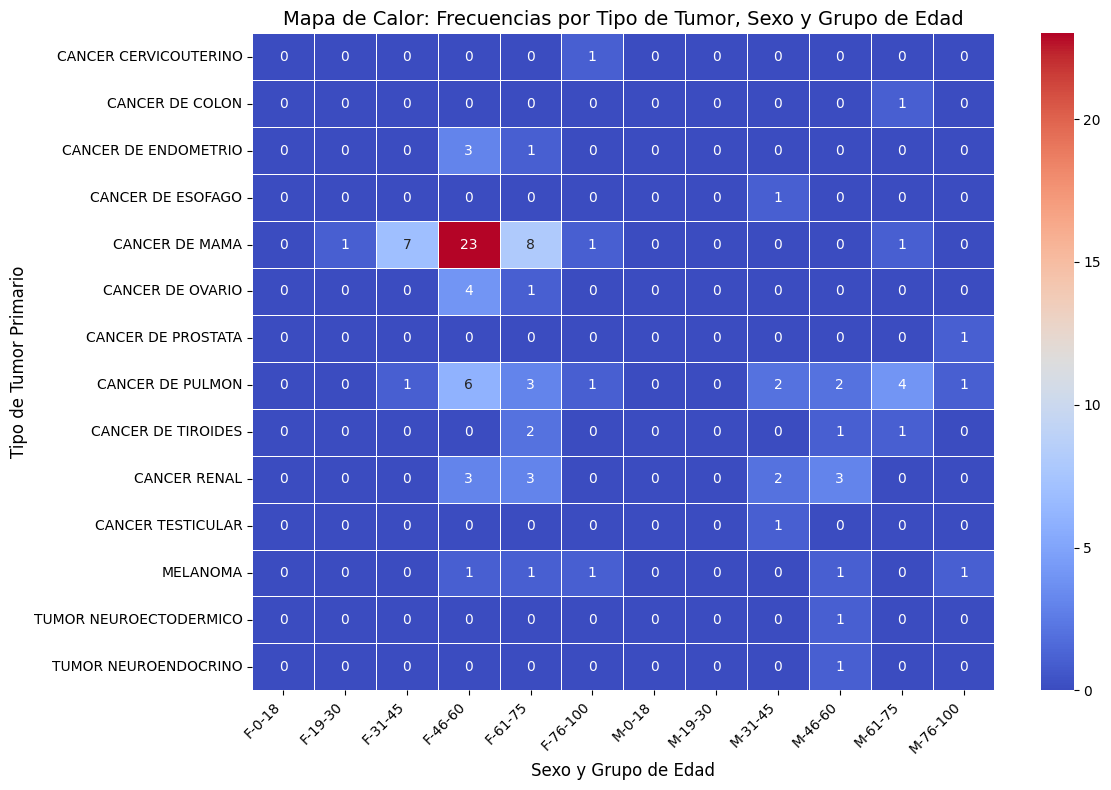

In [16]:
# Crear un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(tabla_contingencia, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor: Frecuencias por Tipo de Tumor, Sexo y Grupo de Edad', fontsize=14)
plt.xlabel('Sexo y Grupo de Edad', fontsize=12)
plt.ylabel('Tipo de Tumor Primario', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas de columnas para mejor visibilidad
plt.tight_layout()
plt.show()

In [18]:
columnas_numericas = df_consolidado.select_dtypes(include=[np.number])

columnas_categoricas = ['SEXO_first', 'TUMOR_PRIMARIO_first', 'SRS_<lambda>', 'TECNICA_first']
df_dummies = pd.get_dummies(df_consolidado[columnas_categoricas], drop_first=True)

df_final = pd.concat([columnas_numericas, df_dummies], axis=1)
matriz_correlacion = df_final.corr()

# Filtrar correlaciones respecto a RESPUESTA_BINARIA
if 'RESPUESTA_BINARIA' in df_final.columns:
    correlacion_respuesta = matriz_correlacion['RESPUESTA_BINARIA'].sort_values(ascending=False)
    print("Correlaciones con RESPUESTA_BINARIA:")
    print(correlacion_respuesta)
else:
    print("La columna 'RESPUESTA_BINARIA' no está en el DataFrame final.")

Correlaciones con RESPUESTA_BINARIA:
RESPUESTA_BINARIA                              1.000000
DOSIS_(Gy)_<lambda>                            0.127655
TUMOR_PRIMARIO_first_CANCER DE PULMON          0.118812
EXPEDIENTE_                                    0.113179
TUMOR_PRIMARIO_first_CANCER DE MAMA            0.105089
LOCALIZACION_<lambda>                          0.103980
NUM_TUMORES_count                              0.100390
SRS_<lambda>_DU (dosis única)                  0.075829
TUMOR_PRIMARIO_first_CANCER DE OVARIO          0.054348
TUMOR_PRIMARIO_first_CANCER DE ENDOMETRIO      0.048348
TUMOR_PRIMARIO_first_CANCER DE TIROIDES        0.048348
TECNICA_first_CONOS                            0.033826
TUMOR_PRIMARIO_first_CANCER DE ESOFAGO         0.023793
TUMOR_PRIMARIO_first_TUMOR NEUROENDOCRINO      0.023793
TUMOR_PRIMARIO_first_CANCER DE PROSTATA        0.023793
TECNICA_first_RAPID ARC                        0.023793
TECNICA_first_IMRT                             0.023793
TUMOR_PRIMA